In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)

    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig('scaling.png')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    #ax3.set_ylim([0, 2.25])
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig('cost.pdf')

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=2)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  HF(REDUX)  \
3    2     8       16      1         1        1        6060.0     0.5210   
0    4     8       32      1         1        1        3244.0     0.5765   
4    8     8       64      1         1        1        1683.0     0.6357   
1   16     8      128      2         1        1         906.0     1.1464   
2   24     8      192      3         1        1         619.0     0.9336   

   GW(REDUX)  io_KB_abinit  ...         Xo  DIPOLE_transverse    Dipoles  gpu  \
3     0.0274        0.0012  ...  1493.0000          4020.0000  4020.0000    2   
0     4.0347        0.0010  ...   886.0000          2052.0000  2054.0000    4   
4     1.8022        0.0011  ...   498.2133          1028.0000  1029.0000    8   
1     2.2091        0.0015  ...   290.1122           522.7728   524.0467   16   
2     1.5394        0.0048  ...   190.3601           358.7039   360.6673   24   

   ideal   speedup  efficiency  Self energy    Other    node_h  
3    1.0  1.000000  100.000000     524.0590  21.0020  1.683333  
0    2.0  1.868064   93.403206     264.3396  37.5006  0.901111  
4    4.0  3.600713   90.017825     132.9188  20.7486  0.467500  
1    8.0  6.688742   83.609272      71.5105  18.2224  0.503333  
2   12.0  9.789984   81.583199      47.9312  17.9724  0.515833  

[5 rows x 52 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles         Xo       X  Self energy    Other
3    2        6060.0  4020.0000  1493.0000  1.9390     524.0590  21.0020
0    4        3244.0  2054.0000   886.0000  2.1598     264.3396  37.5006
4    8        1683.0  1029.0000   498.2133  2.1193     132.9188  20.7486
1   16         906.0   524.0467   290.1122  2.1082      71.5105  18.2224
2   24         619.0   360.6673   190.3601  2.0690      47.9312  17.9724

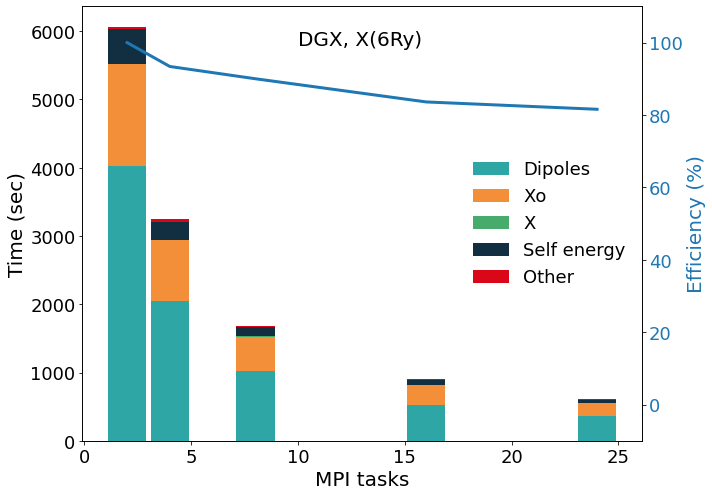

In [9]:
build_scaling_plot(scaling=scaling, pile=pile, colors=colors, bar_width=1.8, efficiency=True,
                   legend_loc='center right', label=r'DGX, X(6Ry)', label_pos=(10, 5800))

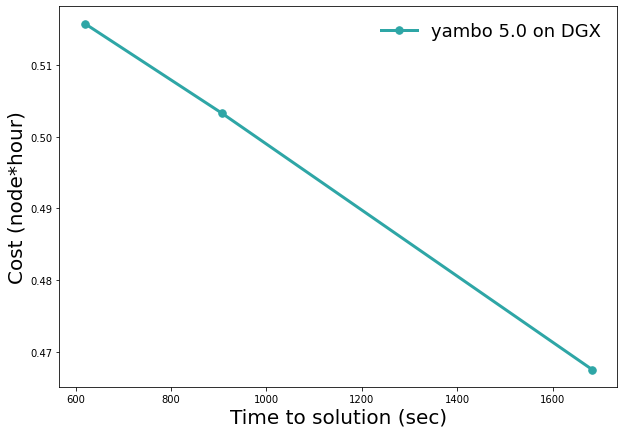

In [10]:
build_cost_plot(scaling=scaling, label='yambo 5.0 on DGX')